In [1]:
#1. IMPORTING PACKAGES AND LIBRARIES
%matplotlib inline
%load_ext autoreload
%autoreload 2
from contextlib import suppress
import os
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from cartopy.io.img_tiles import OSM
from cartopy.io.img_tiles import GoogleTiles as moa
from cycler import cycler
import scipy
import seaborn as sns
import sys
import glob
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import xarray as xr
import pyproj
import osr
import datetime
import subprocess
import shutil
import numpy as np
from ipywidgets import interact
import pandas as pd
import pickle
from scipy.signal import savgol_filter
import time
import statsmodels.api as sm
import statsmodels.formula.api as smf
from pandas.plotting import autocorrelation_plot
from pandas.plotting import lag_plot
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from matplotlib import style
from sklearn import metrics
from sklearn.model_selection import train_test_split 






#own libary
import nsidc 

from functions_pmrs import loadCM

from functions_pmrs import loadCMSAV
from functions_pmrs import applyshift
from functions_pmrs import calculateQR
from functions_pmrs import probability
from functions_pmrs import NQT
from functions_pmrs import calc_performance_scores_new


In [2]:
#SELECT BOUNDS AND START / END DATES
bounds = [( -19., 20.),
          (-11., 27.),
         ]

# start_date = datetim.datetime(2002, 5, 29) # Start of the AMSR-E period
# start_date = datetime.datetime(2004, 1, 1) # date after data recovery
# end_date = datetime.datetime(2009, 12, 31)  # only a few days to make a demonstration
# end_date = datetime.datetime(2004, 6, 30)  # use this end date to cover the whole AMSR-E period.
# end_date = datetime.datetime(2002, 1, 2)

#---------------------------#---------------------------#---------------------------#---------------------------#

#Select set of POI's to use

# points = pd.read_csv('poizambeziplain.csv')   #Kalabo (weinig goede resultaten)
points = pd.read_csv('poi_senaga.csv')
# points = pd.read_csv('POIs_RE_3p.csv')


#adjust according to number of points in POI's
points_interest = [(points.xcoord[0],points.ycoord[0]),
                   (points.xcoord[1],points.ycoord[1])]
#                    (points.xcoord[2],points.ycoord[2]),
#                    (points.xcoord[3],points.ycoord[3]),
#                    (points.xcoord[4],points.ycoord[4])]
#                    (points.xcoord[5],points.ycoord[5])]
#                    (points.xcoord[6],points.ycoord[6]) 


# Download discharge data, no adjustment 
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',parse_dates=['DATE'],index_col = ['DATE'],na_filter=True)
# dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';',na_filter=True) #,parse_dates=['DATE'],index_col = ['DATE']
# dQ['Date'] = pd.to_datetime(dQ['Date'])



#---------------------------#---------------------------#---------------------------#---------------------------#

# DOWNLOAD THE CORRECT DATA
# This cell calls the right download and "glues" the years together. 

fns=None

year = 2009  #change year to select specific year to see [2002-2011]

# 25 km resolution AMSRE DATA
# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/*.nc') # select this line to get the whole AMSR-E period

#select this next one for full period data string (whole DSMP period)
fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/25km36ghz/DMSP/*.nc') # select this line to get the whole AMSR-E period

# 3.125 km resolution AMSRE DATA

# fns = glob.glob(f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/NSIDC_Test_{year}.nc')
#select this next one for full period data string (whole AMSR period)
# fns = glob.glob('/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/Sat_Data/3km36ghz/*.nc') # select this line to get the whole AMSR-E period

# SAT='ASMR-E'
SAT='DSMP'

fns.sort()
ds = xr.open_mfdataset(fns)

#---------------------------#---------------------------#---------------------------#---------------------------#

# Discharge data location
# location = 'Kalabo'  
location = 'Senanga'
# location = 'Lukulu'


#---------------------------#---------------------------#---------------------------#---------------------------#


# TRANSFORMING, NO ADJUSTMENT NEEDED
proj4str = '+proj=cea +lat_0=0 +lon_0=0 +lat_ts=30 +x_0=0 +y_0=0 +ellps=WGS84 +datum=WGS84 +units=m'
# we define a projection object for lat-lon WGS84 (EPSG code 4326)
proj_out = pyproj.Proj(init='epsg:4326')
# we define a projection object for the projection used in the downloaded grids.
proj_in = pyproj.Proj(proj4str)

# here we convert the coordinates in lat-lon into the coordinate system of the downloaded grids.
bounds_xy = nsidc.proj_coords(bounds, proj_out, proj_in)
points_xy = nsidc.proj_coords(points_interest, proj_out, proj_in)
points_x, points_y = zip(*points_xy)

#---------------------------#---------------------------#---------------------------#---------------------------#
sns.set()

<ipython-input-2-b44d6afd4d19>:65: FutureWarning: In xarray version 0.15 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(fns)
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/xarray/backends/api.py:926: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  combined = auto_combine(
/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pyproj/crs.py:77: Fut

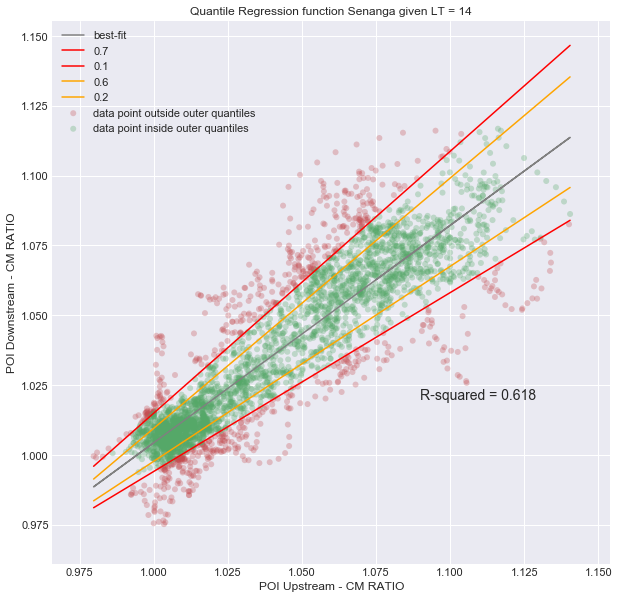

/Users/oscarkeunen/opt/anaconda3/envs/afstuderen/lib/python3.8/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


,POI1,POI4
1988-01-01,1.000000,1.013838
1988-01-02,1.000000,1.014633
1988-01-03,1.000000,1.015182
1988-01-04,1.000000,1.015510
1988-01-05,1.000000,1.015644
...,...,...
2017-06-26,1.027125,1.015615
2017-06-27,1.025430,1.017270
2017-06-28,1.025632,1.020008
2017-06-29,1.025722,1.023953


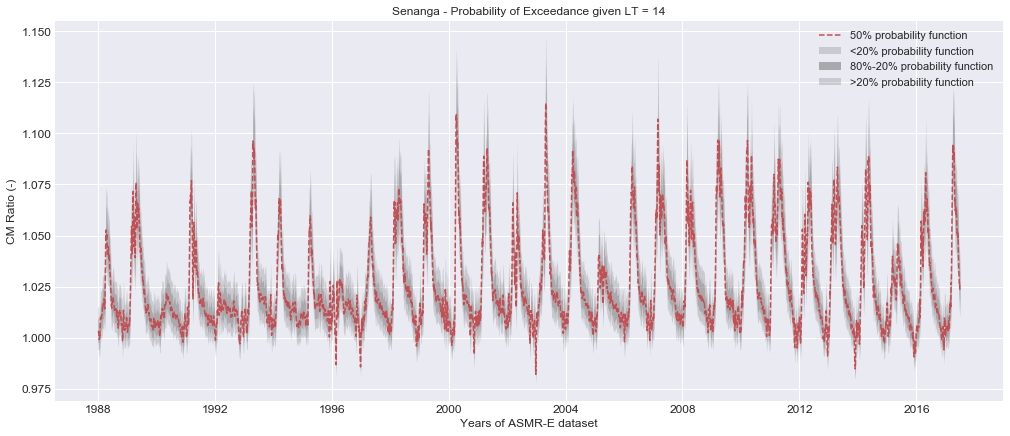

In [3]:

shift= 14
plot=0
rollingvalue = 1
selection= 5 # < number of months to be choosen
windowlength =21
polyorder =3


df = loadCMSAV(points_xy, ds, windowlength, polyorder)


df = applyshift(df,rollingvalue,shift,plot,SAT)
plot=0
df=df


plot=1
fits,res = calculateQR(df,selection,plot,shift,location)
pred = probability(df, fits, plot, shift,location)

df

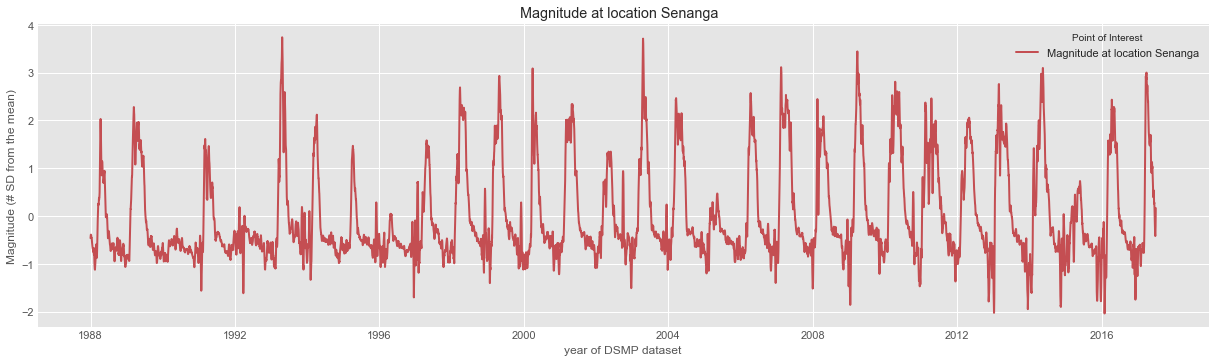

In [4]:

m = (df.POI4 - np.mean(df.POI4)) / np.std(df.POI4)

style.use('ggplot')
fig = plt.figure(figsize=(21,19))
ax1 = fig.add_subplot(311,frameon = True,)
# ax1.set_xticks(dQ.Senanga.index,dQ.Date.year) 
ax1.plot(m, color='r',linewidth =2, label = (f'Magnitude at location {location}'),)
ax1.set(xlabel=(f"year of DSMP dataset"), ylabel="Magnitude (# SD from the mean)",title=(f"Magnitude at location {location}  "))
ax1.yaxis.tick_left() 
ax1.legend(loc=1, title ='Point of Interest',fancybox=True)

    
# ax2 = fig.add_subplot(311, frameon=False, sharex=ax1)   # sharex=ax1,
# ax2.plot(df_total.POI_downstream  ,marker='.', markersize=3,  color='b', label = (f'CM ratio at {location} - rolling median of 6'))
# ax2.set(ylabel="CM ratio [-]")
# ax2.yaxis.set_label_position("right")
# ax2.ylim =[-0.970, 1.020]
# ax2.legend(loc=1, title ='Point of Interest',fancybox=True)
# ax2.yaxis.tick_right()


In [5]:
dQ = pd.read_csv('ZAMBEZIDISCHARGE.csv',sep=';')#, header=0, parse_dates=[0], index_col=0, squeeze=False, na_filter=True)#, parse_dates=['DATE'],index_col = ['DATE'])

dQ['Datetime'] = pd.to_datetime(dQ['Date'], format='%d-%m-%Y')
dQ = dQ.set_index('Datetime')
dQ= dQ[dQ.index.year>1987]
dQ= dQ[dQ.index.year<2017]
dQ=dQ.sort_index()
dQ =dQ.drop('Date', 1) 

df =  df[df.index.year<2017]


Text(0.5, 1.0, 'CM vs Discharge')

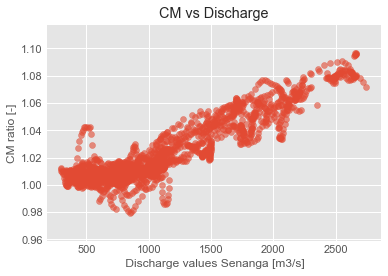

In [6]:

                       
df_total= pd.concat([dQ , df['POI4']], join="outer",  axis=1, ignore_index=False)

df_total.columns=['Q_Kalobo','Q_Senanga','POI_downstream']


df_total= df_total[df_total.index.month>0]
df_total= df_total[df_total.index.month<5]

df_total=df_total.dropna()

plt.scatter(df_total['Q_Senanga'].values,df_total['POI_downstream'].values,alpha=0.6)
style.use('ggplot')

plt.xlabel(' Discharge values Senanga [m3/s]')
plt.ylabel('CM ratio [-]')
plt.title('CM vs Discharge')

           2
9.905e-09 x + 9.263e-06 x + 0.9974


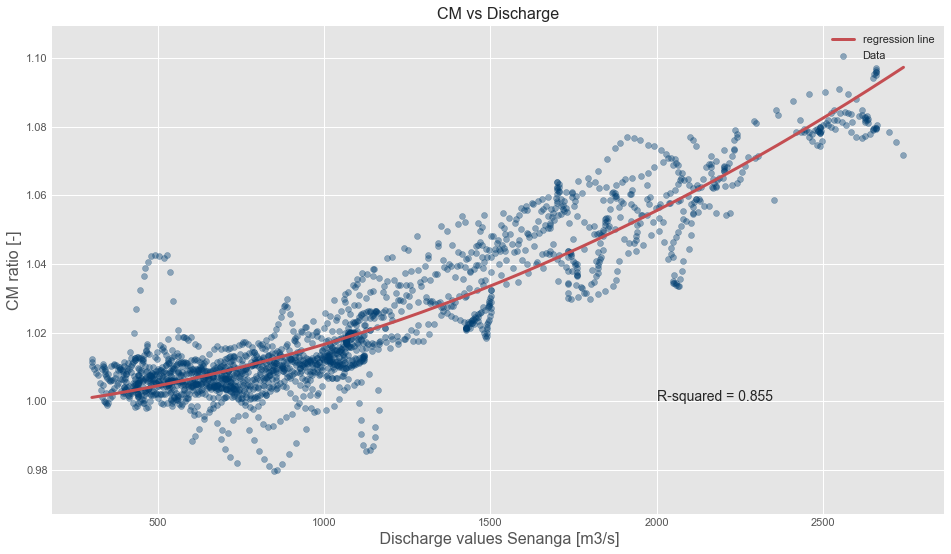

In [18]:


from sklearn.metrics import r2_score




x = df_total['Q_Senanga'].values

y = df_total['POI_downstream'].values
deg =2

z = np.polyfit(x,y,2)
p = np.poly1d(z)
coefficient_of_dermination = r2_score(y, p(x))

print(p)
# print("{:.2f}".format(round(p, 2)))

plt.figure(figsize=(16,9))
plt.scatter(x,y,color='#003F72', label='Data',alpha=0.4)
style.use('ggplot')

plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, deg))(np.unique(x)), 'r-', label='regression line',linewidth =3)

plt.xlabel(' Discharge values Senanga [m3/s]',fontsize=16)
plt.ylabel('CM ratio [-]',fontsize=16)
plt.title('CM vs Discharge',fontsize=16)
plt.text(2000,1, f'R-squared = %0.3f' %coefficient_of_dermination, fontsize =14)
# plt.text(2000,0.98,f'Regression formula=    {formatted_p}', fontsize =14)

plt.legend()


# _ = plt.plot(x, p(x), '-', label='regression line',linewidth =3)

# plt.xlabel(' Discharge values Senanga [m3/s]')
# plt.ylabel('CM ratio [-]')
# plt.title('CM vs Discharge')


In [18]:

p(2142.0)

1.062669967032194

In [19]:
# calculate spearmans's rank correlation
coef_sr , p_sr = spearmanr(df_total['Q_Senanga'].values,df_total['POI_downstream'].values, nan_policy='omit')

# calculate kendall's correlation
coef_kendall, p_kendall = kendalltau(df_total['Q_Senanga'].values,df_total['POI_downstream'].values, nan_policy='omit') #, method = 'asymptotic'


In [20]:
print('Spearmans correlation coefficient: %.3f' % coef_sr)
# interpret the significance
alpha = 0.05
if p_sr > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.6f' % p_sr)
else:
    print('Samples are correlated (reject H0) p=%.6f' % p_sr)
    
print('Kendall correlation coefficient: %.3f' % coef_kendall)
# interpret the significance
alpha = 0.05
if p_kendall > alpha:
    print('Samples are uncorrelated (fail to reject H0) p=%.6f' % p_kendall)
else:
    print('Samples are correlated (reject H0) p=%.6f' % p_kendall)


Spearmans correlation coefficient: 0.833
Samples are correlated (reject H0) p=0.000000
Kendall correlation coefficient: 0.654
Samples are correlated (reject H0) p=0.000000


Text(0.5, 1.0, 'CM vs Discharge')

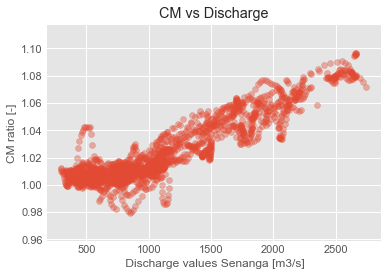

In [21]:
plt.scatter(df_total['Q_Senanga'].values,df_total['POI_downstream'].values,alpha=0.4)
style.use('ggplot')

plt.xlabel(' Discharge values Senanga [m3/s]')
plt.ylabel('CM ratio [-]')
plt.title('CM vs Discharge')

In [23]:

# fig = plt.figure(figsize=(19,21))

# style.use('ggplot')
# ax1 = fig.add_subplot(311)
# ax1.plot(df_t.Senanga.values, color='g', label = (f'Discharge in {year} location {location}'))
# ax1.legend()
# ax1.set(xlabel=(f"Day in the year {year} "),ylabel="Discharge [m3/s]",title=(f"CM ratio vs Discharge at location {location} in {year} "),ylim =[0, 3400]);
# ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

    
    
# ax2 = fig.add_subplot(311, frameon=False,sharex=ax1,)   
# ax2.plot(df ,marker='.', markersize=3, color='b', label = (f'CMvsQ_{year}_{location}_POI{n+1} - rolling median'))
# ax2.set(ylabel="CM ratio [-]")
# ax2.yaxis.set_label_position("right")
# ax2.ylim =[-0.970, 1.020]
# ax2.legend(loc=2, title ='Point of Interest',fancybox=True)
# ax2.yaxis.tick_right()



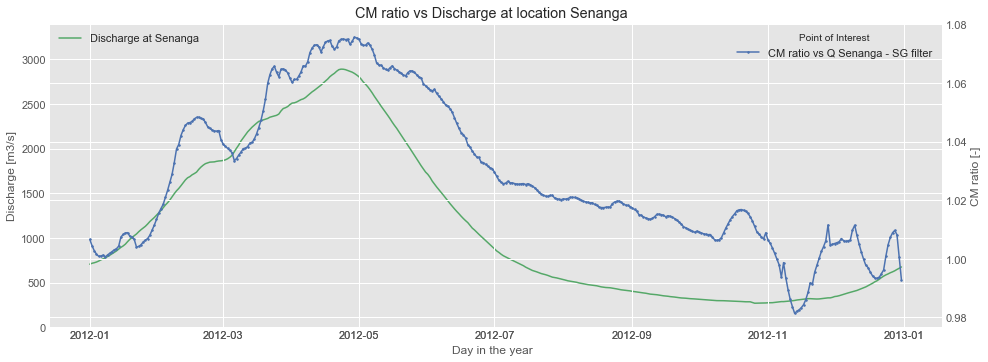

In [47]:
year=2012
df_total= pd.concat([dQ , df['POI4']], join="outer",  axis=1, ignore_index=False)

df_total.columns=['Q_Kalobo','Q_Senanga','POI_downstream']

df_total= df_total[df_total.index.year==year]
# df_total= df_total[df_total.index.year<2017]
# df_total= df_total[df_total.index.year>1987]

# df_total.POI_downstream= df_total.POI_downstream[df_total.POI_downstream>0.995]

style.use('ggplot')

fig = plt.figure(figsize=(16,19))


#     plt.plot(df[n] ,marker='.', markersize=1,label= (f'CM ratio at POI{n}- SG filter'))
ax1 = fig.add_subplot(311)
# ax1.set_xticks(dQ.Senanga.index,dQ.Date.year) 

ax1.plot(df_total.Q_Senanga, color='g', label = (f'Discharge at {location}'))
ax1.legend(loc=2)
ax1.set(xlabel=(f"Day in the year  "), ylabel="Discharge [m3/s]",title=(f"CM ratio vs Discharge at location {location}  "),ylim =[0, 3400]);
ax1.yaxis.tick_left() 

ax2 = fig.add_subplot(311, frameon=False,sharex=ax1)   # sharex=ax1,
ax2.plot(df_total.POI_downstream ,marker='.', markersize=3, color='b', label = (f'CM ratio vs Q {location} - SG filter'))
ax2.set(ylabel="CM ratio [-]")
ax2.yaxis.set_label_position("right")
ax2.ylim =[-0.970, 1.020]
ax2.legend(loc=1, title ='Point of Interest',fancybox=True)
ax2.yaxis.tick_right()

plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Final/CMvsQ{year}_{location}POI5.png'),dpi=400)



In [26]:
ROC =np.zeros((5,4))
plot=0

for percentile in range(5):
    obs = p(df_total.Q_Senanga)
    pred = probability(df, fits, plot, shift,location)

        
    performance, output, metric = calc_performance_scores_new(df, obs, pred, threshold , dt, percentile)



NameError: name 'threshold' is not defined

In [14]:
# Run the ROC figures over the threshold bounds
ROC =np.zeros((11,5,4))
shift =14
plot=0
dt=7
rollingvalue=1 
polyorder =3
windowlength=21


df = loadCMSAV(points_xy,ds,windowlength, polyorder)
df = applyshift(df,rollingvalue,shift,plot,SAT)
df.POI1.fillna(1, inplace=True)
df.POI4.fillna(1, inplace=True)
df =df

for i, n in enumerate([1.03,1.04,1.05, 1.06,1.07, 1.08,1.09 ,1.10, 1.11, 1.12]):#
    threshold = n




    
    fits,res = calculateQR(df,selection,plot,shift,location)
    obs = p(df_total.Q_Senanga)
    pred = probability(df, fits, plot, shift,location)
    
    
    for percentile in range(5):
        obs = p(df_total.Q_Senanga)
        pred = probability(df, fits, plot, shift,location)
        
        
#         print(f'percentile: {percentile}')
        performance, output, metric = calc_performance_scores_new(df, obs, pred, threshold , dt, percentile)
        
#         print(performance)
#         print(output)
        print(metric)
        ROC[i, percentile]= output

# ROC



/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:275: RuntimeWarning: invalid value encountered in greater
  obs_threshold = np.where((obs[df_nqt[t]: df_nqt[t]+365]) > threshold)[0]
/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:302: RuntimeWarning: invalid value encountered in greater
  obs_threshold2 = np.where(obs[pred_threshold3-dt:pred_threshold3+dt] > threshold)[0]


[14.  5.  7.  4.]
[15.  9.  3.  3.]
[14. 11.  2.  3.]
[12. 17.  0.  1.]
[ 8. 22.  0.  0.]
[ 9.  4. 11.  6.]
[14.  7.  4.  5.]
[14. 13.  0.  3.]
[12. 15.  0.  3.]
[ 8. 21.  0.  1.]
[ 2.  4. 16.  8.]
[11.  6.  6.  7.]
[14. 11.  0.  5.]
[13. 13.  0.  4.]
[10. 17.  0.  3.]
[ 1.  3. 16. 10.]
[ 5.  5. 12.  8.]
[11.  8.  3.  8.]
[10. 15.  0.  5.]
[ 6. 20.  0.  4.]
[ 1.  0. 13. 16.]
[ 3.  4. 11. 12.]
[7. 7. 7. 9.]
[ 8. 14.  1.  7.]
[ 5. 20.  0.  5.]
[ 0.  0. 13. 17.]
[ 1.  3. 12. 14.]
[ 5.  7.  7. 11.]
[ 6. 12.  3.  9.]
[ 2. 22.  0.  6.]
[ 0.  0. 10. 20.]
[ 1.  1.  9. 19.]
[ 5.  4.  5. 16.]
[ 7.  9.  2. 12.]
[ 4. 18.  0.  8.]
[ 0.  0.  6. 24.]
[ 0.  1.  6. 23.]
[ 1.  2.  5. 22.]
[ 4.  8.  2. 16.]
[ 3. 16.  0. 11.]
[ 0.  0.  3. 27.]
[ 0.  0.  3. 27.]
[ 0.  1.  3. 26.]
[ 1.  4.  2. 23.]
[ 2. 11.  1. 16.]
[ 0.  0.  3. 27.]
[ 0.  0.  3. 27.]
[ 0.  0.  3. 27.]
[ 0.  3.  3. 24.]
[ 2.  7.  1. 20.]


<ipython-input-15-985ef6e82dff>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-15-985ef6e82dff>:19: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


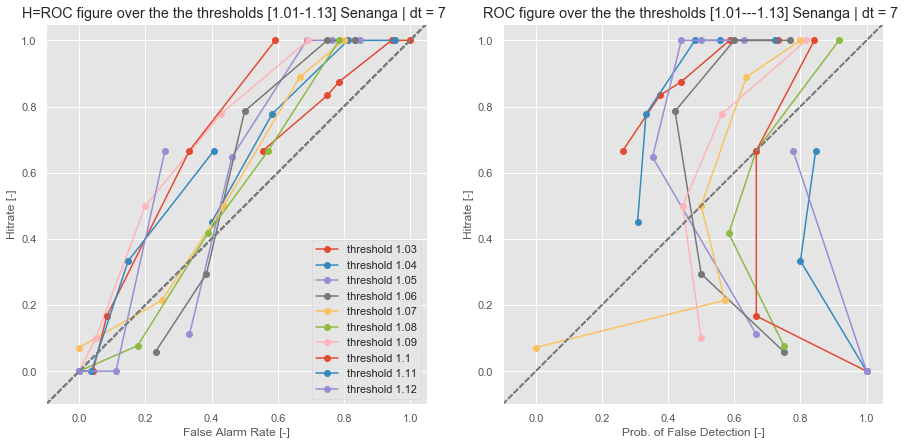

In [15]:
plt.figure(figsize=(15,15))

for n in range (10):

    plt.subplot(1,2,1)
    plt.plot(ROC[n,:,2],ROC[n,:,0],'-o',label=f'threshold {1.03+n*0.01}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'H=ROC figure over the the thresholds [1.01-1.13] {location} | dt = {dt} ')
    plt.ylabel('Hitrate [-]')
    
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    plt.xlabel('False Alarm Rate [-]')
    plt.legend(loc='best')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(ROC[n,:,1],ROC[n,:,0],'-o',label=f'threshold {1.03+n*0.01}')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over the the thresholds [1.01---1.13] {location} | dt = {dt} ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    

    plt.gca().set_aspect('equal', adjustable='box')
#     plt.legend(loc='best')
    plt.draw()  
# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/ROCthreshold_dt{dt}_{location}_{SAT}.png'),dpi=400)


In [16]:
# Run the ROC figures over all the dt positions
ROC =np.zeros((20,5,4))
threshold =1.074
shift= 14
plot=0
rollingvalue=1
windowlength=21
polyorder=3

df = loadCMSAV(points_xy,ds,windowlength, polyorder)
df = applyshift(df,rollingvalue,shift,plot,SAT)
df=df


for i, n in enumerate(range(2, 15, 1)):
    dt = n
    fits,res = calculateQR(df,selection,plot,shift,location)


    obs = p(df_total.Q_Senanga)
    pred = probability(df, fits, plot, shift,location)
    for percentile in range(5):
        
        obs = p(df_total.Q_Senanga)
        pred = probability(df, fits, plot, shift,location)
        
        performance, output, metric = calc_performance_scores_new(df, obs, pred, threshold , dt, percentile)
        
        ROC [i, percentile]= output
        print(metric)


# ROC


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:275: RuntimeWarning: invalid value encountered in greater
  obs_threshold = np.where((obs[df_nqt[t]: df_nqt[t]+365]) > threshold)[0]


[ 0.  0. 14. 16.]


/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/functions_pmrs.py:302: RuntimeWarning: invalid value encountered in greater
  obs_threshold2 = np.where(obs[pred_threshold3-dt:pred_threshold3+dt] > threshold)[0]


[ 1.  3. 13. 13.]
[ 2.  7. 11. 10.]
[ 0. 17.  5.  8.]
[ 1. 22.  1.  6.]
[ 0.  0. 14. 16.]
[ 1.  3. 13. 13.]
[ 3.  7. 10. 10.]
[ 6. 12.  4.  8.]
[ 2. 22.  0.  6.]
[ 0.  0. 14. 16.]
[ 2.  3. 12. 13.]
[ 4.  7.  9. 10.]
[ 7. 12.  3.  8.]
[ 3. 21.  0.  6.]
[ 0.  0. 14. 16.]
[ 2.  3. 12. 13.]
[ 6.  7.  7. 10.]
[ 7. 12.  3.  8.]
[ 4. 20.  0.  6.]
[ 1.  0. 13. 16.]
[ 2.  3. 12. 13.]
[ 7.  7.  6. 10.]
[ 7. 12.  3.  8.]
[ 4. 20.  0.  6.]
[ 1.  0. 13. 16.]
[ 2.  3. 12. 13.]
[ 8.  6.  6. 10.]
[ 9. 12.  1.  8.]
[ 5. 19.  0.  6.]
[ 1.  0. 13. 16.]
[ 4.  3. 10. 13.]
[ 9.  6.  5. 10.]
[ 9. 12.  1.  8.]
[ 6. 18.  0.  6.]
[ 1.  0. 13. 16.]
[ 5.  3.  9. 13.]
[10.  6.  4. 10.]
[ 9. 12.  1.  8.]
[ 6. 18.  0.  6.]
[ 2.  0. 12. 16.]
[ 6.  3.  8. 13.]
[10.  6.  4. 10.]
[10. 11.  1.  8.]
[ 6. 18.  0.  6.]
[ 2.  0. 12. 16.]
[ 6.  3.  8. 13.]
[10.  6.  4. 10.]
[10. 11.  1.  8.]
[ 6. 18.  0.  6.]
[ 2.  0. 12. 16.]
[ 8.  3.  6. 13.]
[10.  6.  4. 10.]
[11. 10.  1.  8.]
[ 8. 16.  0.  6.]
[ 2.  0. 12. 16.]
[ 9.  3.  

<ipython-input-17-704fe8d562c1>:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,1)
<ipython-input-17-704fe8d562c1>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,2,2)


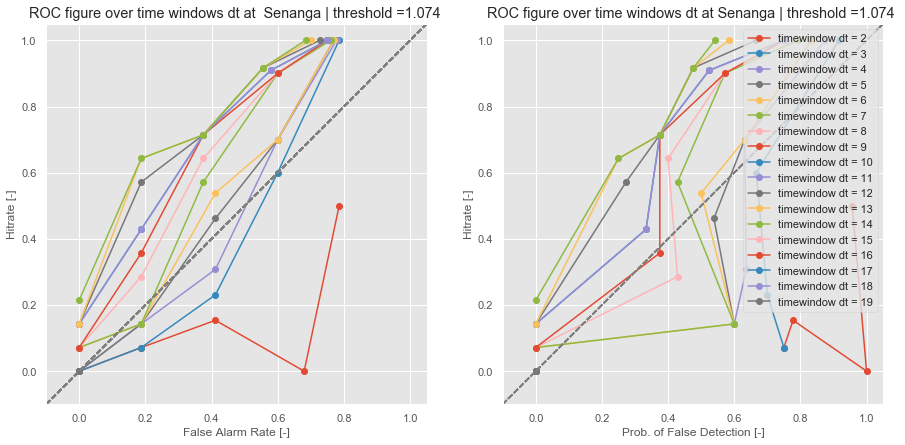

In [17]:
plt.figure(figsize=(15,15))

for n in range (18):

    plt.subplot(1,2,1)
    plt.plot(ROC[n,:,2],ROC[n,:,0],'-o',label= f'timewindow dt ={n+2}') #color ='b')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over time windows dt at  {location} | threshold ={threshold} ')
    plt.ylabel('Hitrate [-]')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")
    plt.xlabel('False Alarm Rate [-]')
#     plt.legend(loc='best')
    plt.gca().set_aspect('equal', adjustable='box')
    plt.draw()


    plt.subplot(1,2,2)
    plt.plot(ROC[n,:,1],ROC[n,:,0],'-o',label=f'timewindow dt = {n+2}')#'-o',color ='r')
    plt.xlim([-0.1,1.05])
    plt.ylim([-0.1,1.05])
    plt.title(f'ROC figure over time windows dt at {location} | threshold ={threshold} ')
    plt.ylabel('Hitrate [-]')
    plt.xlabel('Prob. of False Detection [-]')
    plt.plot(plt.xlim(), plt.ylim(), ls="--", c=".5")

    plt.gca().set_aspect('equal', adjustable='box')
    plt.legend(loc='upper right')
    plt.draw()  

# plt.savefig((f'/Users/oscarkeunen/Documents/1. TU Delft/1. Msc - Watermanagement/Afstuderen/satellite-cookbook-master/NSIDC-AMSRE/figures_python/Midterm/ROC_overdtwiththreshold{threshold}_{location}_{SAT}.png'),dpi=400)
